# MNIST Digits with Pytorch

A demo from the video [The Three Elements of PyTorch][1] by [SebastianRaschka][3] with [source code in Github][2].

[1]: https://www.youtube.com/watch?v=nf-r9gnum7o
[2]: https://github.com/rasbt/machine-learning-notes/blob/main/demos/basic-pytorch-cnn-for-3-ele-pytorch-video.ipynb
[3]: https://sebastianraschka.com/

In [1]:
import os
import time

import numpy as np
import torch
import torch.nn.functional as F
import torchvision

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10

In [4]:
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
}

Grab [MNIST dataset from Sebastian Raschka][1]

[1]: https://github.com/rasbt/mnist-pngs

In [5]:
import os
from git import Repo

if not os.path.exists('data/mnist-pngs'):
    Repo.clone_from("https://github.com/rasbt/mnist-pngs", "data/mnist-pngs")

In [6]:
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_dset = ImageFolder(root="data/mnist-pngs/train", transform=data_transforms["train"])

train_dset, valid_dset = random_split(train_dset, lengths=[55000, 5000])

test_dset = ImageFolder(root="data/mnist-pngs/test", transform=data_transforms["test"])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

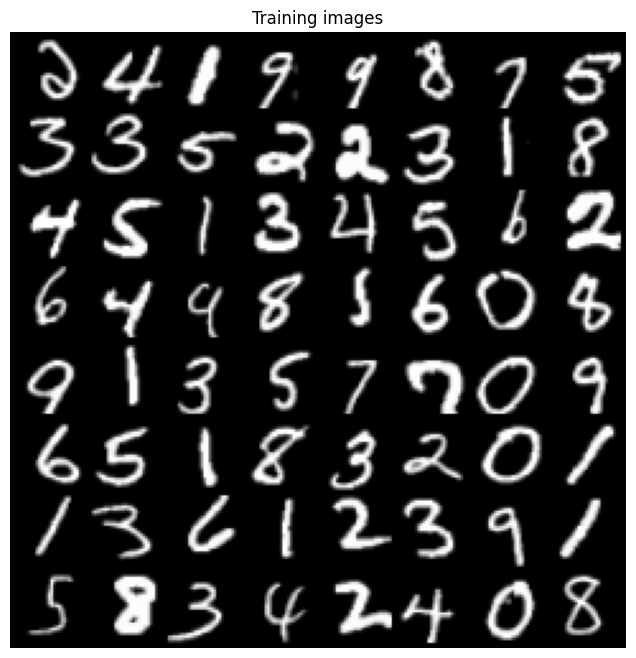

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.utils as vutils

real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

In [9]:
real_batch = next(iter(train_loader))
print(
    type(real_batch[0]), type(real_batch[1]),
    real_batch[0].shape,
    real_batch[1].shape,
)

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([128, 3, 28, 28]) torch.Size([128])


## Model

In [72]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


torch.manual_seed(random_seed)
model = PyTorchCNN(num_classes=num_classes)
model = model.to(device)

In [73]:
print(model)

PyTorchCNN(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Training

In [74]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float() / num_examples

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features, targets = features.to(device), targets.to(device)

        ### Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        ### Backward pass (backpropagation)
        optimizer.zero_grad()
        loss.backward()

        ### Update model parameters
        optimizer.step()

        ### Batch-level logging
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )

    ### Epoch-level logging
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader, device)
    valid_acc = compute_accuracy(model, valid_loader, device)
    print(
        f"Training accuracy: {train_acc * 100:.2f}% | "
        f"Validation accuracy: {valid_acc * 100:.2f}%"
    )
    print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

print(f"Total training time: {(time.time() - start_time) / 60:.2f} min")

Epoch: 001/010 | Batch: 100/429 | Loss: 0.4992
Epoch: 001/010 | Batch: 200/429 | Loss: 0.2460
Epoch: 001/010 | Batch: 300/429 | Loss: 0.1491
Epoch: 001/010 | Batch: 400/429 | Loss: 0.1830
Training accuracy: 95.29% | Validation accuracy: 94.98%
Time elapsed: 0.40 min
Epoch: 002/010 | Batch: 100/429 | Loss: 0.1685
Epoch: 002/010 | Batch: 200/429 | Loss: 0.0773
Epoch: 002/010 | Batch: 300/429 | Loss: 0.0913
Epoch: 002/010 | Batch: 400/429 | Loss: 0.0497
Training accuracy: 97.28% | Validation accuracy: 96.54%
Time elapsed: 0.82 min
Epoch: 003/010 | Batch: 100/429 | Loss: 0.0749
Epoch: 003/010 | Batch: 200/429 | Loss: 0.0857
Epoch: 003/010 | Batch: 300/429 | Loss: 0.0984
Epoch: 003/010 | Batch: 400/429 | Loss: 0.0620
Training accuracy: 97.27% | Validation accuracy: 97.20%
Time elapsed: 1.20 min
Epoch: 004/010 | Batch: 100/429 | Loss: 0.0655
Epoch: 004/010 | Batch: 200/429 | Loss: 0.0314
Epoch: 004/010 | Batch: 300/429 | Loss: 0.0446
Epoch: 004/010 | Batch: 400/429 | Loss: 0.0420
Training ac

## Evaluation

In [76]:
test_acc = compute_accuracy(model, test_loader, device)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 99.16%


## Model demo

Predict your own hand-drawn digits.

The following uses [ipywidgets][1] to provide a little interactive demo. I'm not sure I'd recommend this approach as I had to go pretty far into the weeds to get it to work and it's probably super-fragile to changes in Jupyter notebooks. Since it's not going to render nicely in GitHub, here's a [screenshot][2].

[1]: https://ipywidgets.readthedocs.io/en/latest/
[2]: https://github.com/cbare/notes-on-deep-learning/blob/master/images/predict-hand-written-digits.jpg

In [144]:
def draw_bar_plot(scores, predicted_label):
    plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots()
    
    ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
    ax.set_axisbelow(True)
    fig = ax.bar(
        range(0,10),
        scores,
        color='#336699',
        edgecolor='k',
        capsize=5
    )
    plt.title(f'Predicted digit = {predicted_label}')
    plt.xticks(range(10), range(10))
    plt.grid(color="#eeeeee")
    plt.show()

In [145]:
from IPython.display import display, HTML, Javascript
import base64
import io
from PIL import Image

# Function to handle the image data in Python
def handle_drawn_image(image_data):
    # Decode the image data
    image_bytes = base64.b64decode(image_data.split(',')[1])
    with io.BytesIO(image_bytes) as image_buffer:
        image_buffer.seek(0)
        with Image.open(image_buffer) as image:
            print(image.size)

            # Resize and process the image as needed, e.g., resize to 28x28 for MNIST
            image = image.convert("RGB").resize((28, 28), Image.LANCZOS)

            # Convert to a PyTorch Tensor and normalize
            transform = transforms.Compose([
                transforms.ToTensor(),
                # normalize images to [-1, 1] range
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            image_tensor = transform(image)

    # Create a batch with size 1
    batch_tensor = image_tensor.unsqueeze(0)

    # Predict
    with torch.no_grad():  # Disable gradient computation for inference
        logits = model(batch_tensor)
        preds = torch.nn.functional.softmax( (logits - logits.min()) / logits.max(), dim=1 )
        _, predicted_labels = torch.max(logits, 1)

    return preds[0], predicted_labels[0].item()

In [146]:
import io
import base64
from PIL import Image
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML

model_output = {}

# Create widgets
submit_button = widgets.Button(description="Predict")
clear_button = widgets.Button(description="Clear")
output = widgets.Output()

# Text widget to receive the image data URL
image_data_text = widgets.Text()

def handle_change(change):
    with output:
        if change["name"] == "value" and change["new"] != change["old"]:
            logits, predicted_label = handle_drawn_image(change["new"].strip())
            output.clear_output()
            draw_bar_plot(logits, predicted_label)

image_data_text.observe(handle_change, names='value')

def clear(b):
    output.clear_output()

clear_button.on_click(clear)

js = HTML("""
<script>
var canvas = document.getElementById('canvas');
var ctx = canvas.getContext('2d');
var text_input = document.querySelector('input[type="text"]');
var submitButton = document.querySelector('button[title="Predict"]');
var clearButton = document.querySelector('button[title="Clear"]');

// Set up the drawing
var drawing = false;
var prevX = 0, prevY = 0;

ctx.fillStyle = "black";
ctx.fillRect(0, 0, canvas.width, canvas.height);

canvas.addEventListener('mousedown', function(e) {
    drawing = true;
    prevX = e.offsetX;
    prevY = e.offsetY;
});

canvas.addEventListener('mouseup', function(e) {
    drawing = false;
});

canvas.addEventListener('mousemove', function(e) {
    if (drawing) {
        var currX = e.offsetX;
        var currY = e.offsetY;
        draw(prevX, prevY, currX, currY);
        prevX = currX;
        prevY = currY;
    }
});

function draw(x1, y1, x2, y2) {
    ctx.beginPath();
    ctx.strokeStyle = 'white';
    ctx.lineWidth = 30;
    ctx.lineJoin = 'round';
    ctx.moveTo(x1, y1);
    ctx.lineTo(x2, y2);
    ctx.closePath();
    ctx.stroke();
}

function copyImageData() {
    drawing = false;
    var dataURL = canvas.toDataURL('image/png');
    text_input.value = dataURL;  // Set the data URL to the text widget

    // dispatching an input event signals to the ipywidget model that it needs
    // to propagate a change event back to the Python side. This triggers the
    // handle_change function defined in Python earlier.
    var inputEvent = new Event('input', { bubbles: true, cancelable: true });
    text_input.dispatchEvent(inputEvent);
};

function clear() {
    text_input.value = "";
    drawing = false;
    ctx.fillStyle = "black";
    ctx.fillRect(0, 0, canvas.width, canvas.height);
}

submitButton.addEventListener("click", copyImageData);
clearButton.addEventListener("click", clear);
</script>
""")

display(
    HTML("""<canvas id="canvas" width="280" height="280" style="border:1px solid #000000;"></canvas>"""),
    submit_button,
    clear_button,
    image_data_text,
    js,
    output,
)


Button(description='Predict', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

Text(value='')

Output()